In [1]:
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
import json
import copy

# Main qiskit imports
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, execute, Aer, IBMQ

# Error mitigation
# from qiskit.ignis.mitigation.measurement import (complete_meas_cal, 
#                                                 CompleteMeasFitter, 
#                                                 MeasurementFilter)
from qiskit.utils.mitigation import *

# Utility functions
from qiskit.tools.jupyter import *
from qiskit.tools.monitor import job_monitor
from qiskit.providers.jobstatus import JobStatus

# Test
from qiskit import *

In [2]:
# We use ibmq_vigo
# IBMQ.load_account()
# backend = IBMQ.get_provider(hub='ibm-q', group='open', project='main').get_backend('ibmq_vigo')

# Local simulator and vector simulator
simulator = Aer.get_backend('qasm_simulator')

In [3]:
# Circuit Preparation

from amplitude_damping import *

SHOTS = 8192

# The values for R and corresponding times
R_values = [0.2, 100.0, 200.0, 400.0]
npoints = 50
t_values = {}
for R in R_values:
    t_values[R] = np.linspace(0.0, 6.0 * np.pi / np.sqrt(abs(2.0 * R - 1.0)), npoints)

# We create the quantum circuits
q = QuantumRegister(5, name="q")
c = ClassicalRegister(1, name="c")

## Indices of the system and environment qubits
sys = 1
env = 2

## For values of R and thirty values of t for each
circuits = {}
for R in R_values:
    circuits[R] = []
    for t in t_values[R]:
        circuits[R].append(initial_state(q, sys).compose(amplitude_damping_channel(q, c, sys, env, R, t)))

# Calibration circuits
cal_circuits, state_labels = complete_meas_cal([sys], q, c)

C:\Users\dbaso\AppData\Local\Temp\ipykernel_37872\96728924.py:30: DeprecationWarning: The function ``qiskit.utils.mitigation.circuits.complete_meas_cal()`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  cal_circuits, state_labels = complete_meas_cal([sys], q, c)


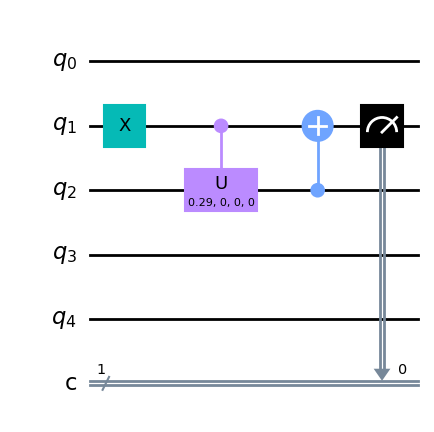

In [4]:
circuits[0.2][1].draw(output='mpl')

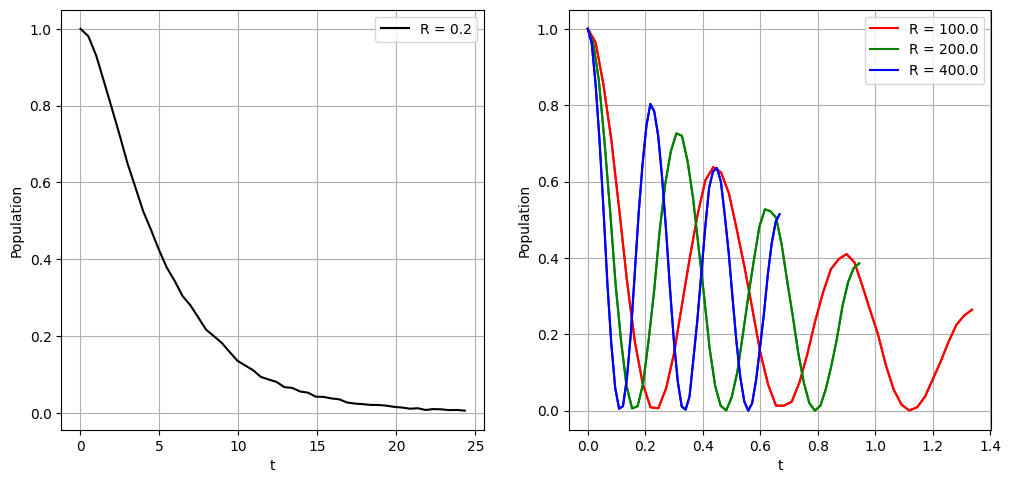

In [5]:
# Simulation
# Execute the circuits on the local simulator
jobs_sim = {}
for R in R_values:
    jobs_sim[R] = execute(circuits[R], backend = simulator, shots = SHOTS)

# Analyse the outcomes
populations_sim = {}
for R in R_values:
    populations_sim[R] = []
    current_job_res = jobs_sim[R].result()
    for i in range(npoints):
        counts = current_job_res.get_counts(i)
        if '1' in counts:
            sm = counts['1']/float(SHOTS)
        populations_sim[R].append(sm)

# Plot the results
fig_idx = 221
plt.figure(figsize=(12,12))

plt.subplot(fig_idx)
plt.plot(t_values[0.2], populations_sim[0.2], c = 'k',label = 'R = 0.2')
plt.xlabel('t')
plt.ylabel('Population')
plt.legend()
fig_idx += 1
plt.grid()

for i,R in enumerate(R_values[1:]):
    c = ['r', 'g', 'b'][i]
    plt.subplot(fig_idx)
    plt.plot(t_values[R], populations_sim[R], c = c, label=r'R = ' + str(R))
    plt.plot(t_values[R], populations_sim[R], c = c, ls = '-')
plt.xlabel('t')
plt.ylabel('Population')
plt.legend()
fig_idx += 1
plt.grid()


Non-Markovianity Set-Up

In [6]:
# Circuit Preparation

from amplitude_damping import *

SHOTS = 8192

# The values for R and corresponding times,
# as well as the observables needed for the witness
observables = ['xx', 'yy', 'zz']
R_values = [0.2, 100.0, 200.0, 400.0]
npoints = 50
t_values = {}
for R in R_values:
    t_values[R] = np.linspace(0.0, 6.0 * np.pi / np.sqrt(abs(2.0 * R - 1.0)), npoints)

# We create the quantum circuits
q = QuantumRegister(5, name="q")
c = ClassicalRegister(2, name="c")

## Indices of the system, environment and ancillary qubits
sys = 1
env = 2
anc = 3

## Two values of R and thirty values of t for each
## The witness requires measuring three observables per point
circuits = {}
for R in R_values:
    circuits[R] = {}
    for observable in observables:
        circuits[R][observable] = []
        for t in t_values[R]:
            circuits[R][observable].append(initial_state_witness(q, sys, anc).compose(amplitude_damping_channel_witness(q, c, sys, env, anc, observable, R, t)))

# Calibration circuits
cal_circuits, state_labels = complete_meas_cal([sys, anc], q, c)

C:\Users\dbaso\AppData\Local\Temp\ipykernel_37872\262473340.py:36: DeprecationWarning: The function ``qiskit.utils.mitigation.circuits.complete_meas_cal()`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  cal_circuits, state_labels = complete_meas_cal([sys, anc], q, c)


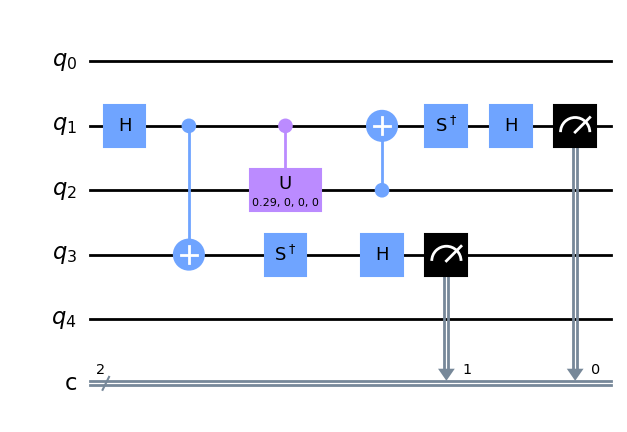

In [7]:
circuits[0.2]['yy'][1].draw(output='mpl')

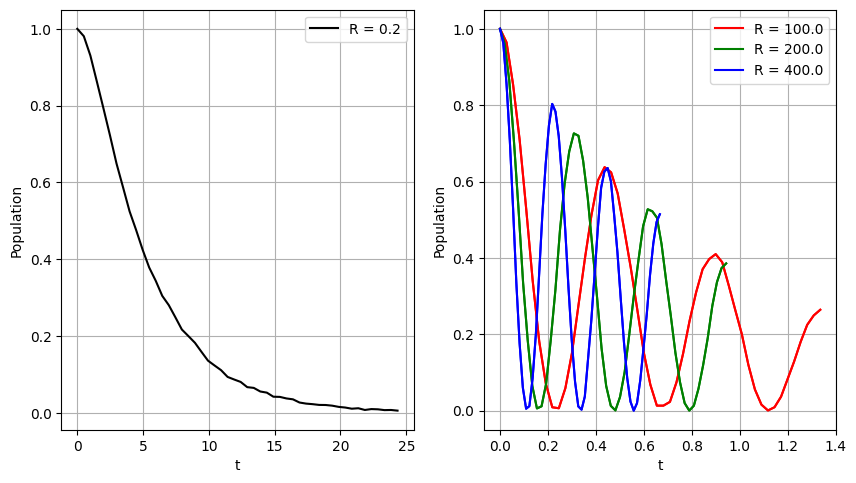

In [8]:
# Execute the circuits on the local simulator
jobs_sim = {}
for R in R_values:
    jobs_sim[R] = {}
    for observable in observables:
        jobs_sim[R][observable] = execute(circuits[R][observable], backend = simulator, shots = SHOTS)

# Analyse the outcomes
## Compute expected values
expected_sim = {}
for R in R_values:
    expected_sim[R] = {}
    for observable in observables:
        expected_sim[R][observable] = []
        current_job_res = jobs_sim[R][observable].result()
        for i in range(npoints):
            counts = current_job_res.get_counts(i)
            expc = 0.0
            for outcome in counts:
                if outcome[0] == outcome[1]:
                    expc += counts[outcome]/float(SHOTS)
                else:
                    expc -= counts[outcome]/float(SHOTS)
            expected_sim[R][observable].append(expc)

## Compute witness
witness_sim = {}
for R in R_values:
    witness_sim[R] = []
    for i in range(npoints):
        w = 0.25*(1.0+expected_sim[R]['xx'][i]-expected_sim[R]['yy'][i]+expected_sim[R]['zz'][i])
        witness_sim[R].append(w)

# Plot the results
fig_idx = 221
plt.figure(figsize=(10,12))
plt.subplot(fig_idx)
plt.plot(t_values[0.2], populations_sim[0.2], c = 'k',label = 'R = 0.2')
plt.xlabel('t')
plt.ylabel('Population')
plt.legend()
fig_idx += 1
plt.grid()

for i,R in enumerate(R_values[1:]):
    c = ['r', 'g', 'b'][i]
    plt.subplot(fig_idx)
    plt.plot(t_values[R], populations_sim[R], c = c, label=r'R = ' + str(R))
    plt.plot(t_values[R], populations_sim[R], c = c, ls = '-')
plt.xlabel('t')
plt.ylabel('Population')
plt.legend()
fig_idx += 1
plt.grid()
# for R in R_values:
#     plt.subplot(fig_idx)
#     plt.plot(t_values[R], witness_sim[R], label=r'R = ' + str(R))
#     plt.xlabel('t')
#     plt.ylabel('Population')
#     plt.legend()
#     fig_idx += 1
#     plt.grid()

In [9]:
# # Calibration circuits
# cal_circuits, state_labels = complete_meas_cal([sys, anc], q, c)
# Run the calibration job
calibration_job = execute(cal_circuits, backend = simulator, shots=SHOTS)

# Run the circuits and save the jobs
jobs = {}
for R in R_values:
    jobs[R] = {}
    for observable in observables:
        jobs[R][observable] = execute(circuits[R][observable], backend = simulator, shots = SHOTS)

C:\Users\dbaso\AppData\Local\Temp\ipykernel_37872\2414864704.py:2: DeprecationWarning: The class ``qiskit.utils.mitigation.fitters.CompleteMeasFitter`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  meas_fitter = CompleteMeasFitter(calibration_job.result(), state_labels)


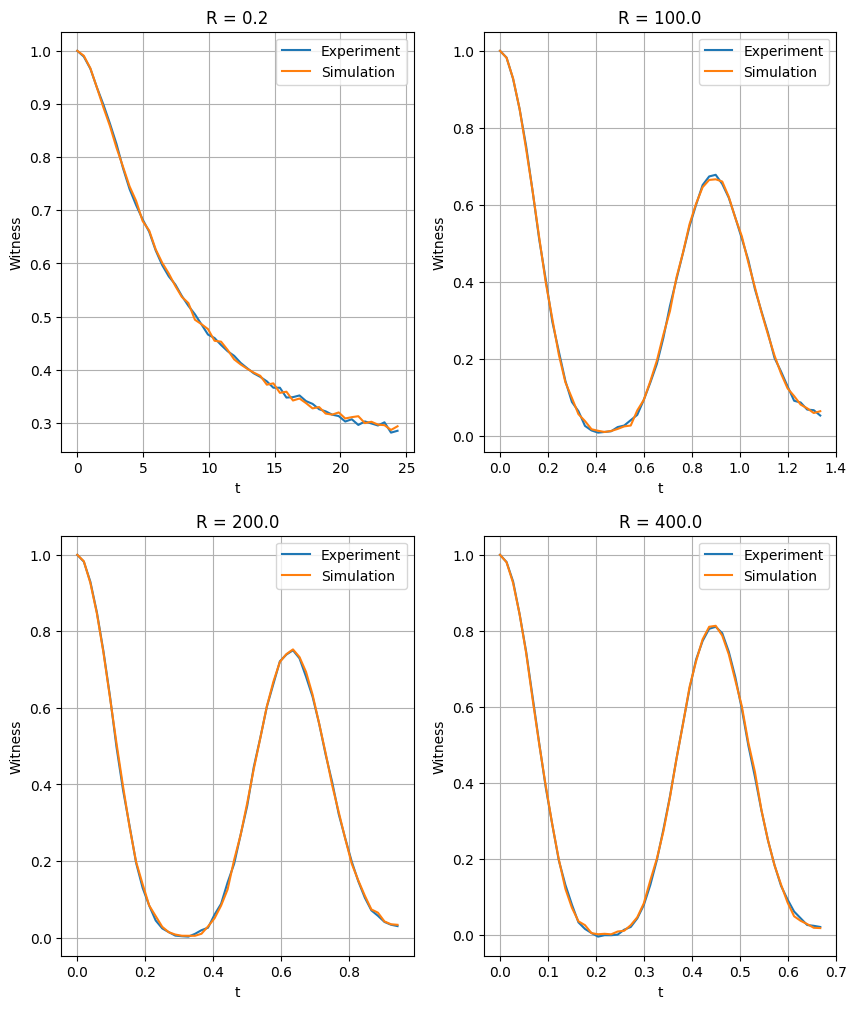

In [10]:
# Use the calibration job to implement the error mitigation
meas_fitter = CompleteMeasFitter(calibration_job.result(), state_labels)
meas_filter = meas_fitter.filter

# Analyse the outcomes
## Compute expected values
expected = {}
for R in R_values:
    expected[R] = {}
    for observable in observables:
        expected[R][observable] = []
        current_job_res = jobs[R][observable].result()
        mitigated_res = meas_filter.apply(current_job_res)
        for i in range(npoints):
            counts = mitigated_res.get_counts(i)
            expc = 0.0
            for outcome in counts:
                if outcome[0] == outcome[1]:
                    expc += counts[outcome]/float(SHOTS)
                else:
                    expc -= counts[outcome]/float(SHOTS)
            expected[R][observable].append(expc)

## Compute witness
witness = {}
for R in R_values:
    witness[R] = []
    for i in range(npoints):
        w = 0.25*(1.0+expected[R]['xx'][i]-expected[R]['yy'][i]+expected[R]['zz'][i])
        witness[R].append(w)

# Plot the results
fig_idx = 221
plt.figure(figsize=(10,12))
for R in R_values:
    plt.subplot(fig_idx)
    plt.plot(t_values[R], witness[R], label='Experiment')
    plt.plot(t_values[R], witness_sim[R], label='Simulation')
    plt.xlabel('t')
    plt.ylabel('Witness')
    plt.title("R = " + str(R))
    plt.legend()
    fig_idx += 1
    plt.grid()
plt.legend();

Non-Markovianity with Noise

In [11]:
# Circuit Preparation

from amplitude_damping import *

SHOTS = 8192

# The values for R and corresponding times,
# as well as the observables needed for the witness
observables = ['xx', 'yy', 'zz']
R_values = [0.2, 100.0, 200.0, 400.0]
npoints = 50
t_values = {}
for R in R_values:
    t_values[R] = np.linspace(0.0, 6.0 * np.pi / np.sqrt(abs(2.0 * R - 1.0)), npoints)

# We create the quantum circuits
q = QuantumRegister(5, name="q")
c = ClassicalRegister(2, name="c")

## Indices of the system, environment and ancillary qubits
sys = 1
env = 2
anc = 3

## Two values of R and thirty values of t for each
## The witness requires measuring three observables per point
circuits = {}
for R in R_values:
    circuits[R] = {}
    for observable in observables:
        circuits[R][observable] = []
        for t in t_values[R]:
            circuits[R][observable].append(initial_state_witness(q, sys, anc).compose(amplitude_damping_channel_witness_noisy(q, c, sys, env, anc, observable, R, t)))

# Calibration circuits

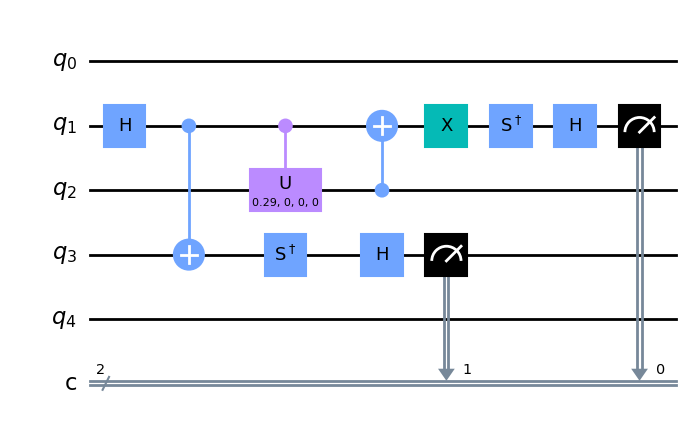

In [12]:

circuits[0.2]['yy'][1].draw(output='mpl')